In [1]:
import os, shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import gdown
import zipfile
import random

In [2]:
target_dir = "dataset"
os.makedirs(target_dir, exist_ok=True)

file_id = "1Ryh2K3Wu2kOMxP4bJmFm8UIkYQ7xgTRw"
output = os.path.join(target_dir, "ML_age_classifier.zip")

gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(target_dir)

print(f"Dataset downloaded and extracted to '{target_dir}'!")

Downloading...
From: https://drive.google.com/uc?id=1Ryh2K3Wu2kOMxP4bJmFm8UIkYQ7xgTRw
To: d:\ML_Research\dataset\ML_age_classifier.zip
100%|██████████| 4.91M/4.91M [00:01<00:00, 3.21MB/s]


Dataset downloaded and extracted to 'dataset'!


In [3]:
source_dir = 'dataset/assessment-data'
target_dir = 'data'
train_ratio = 0.8 

os.makedirs(f'{target_dir}/train', exist_ok=True)
os.makedirs(f'{target_dir}/val', exist_ok=True)

for age in os.listdir(source_dir):
    age_path = os.path.join(source_dir, age)
    if not os.path.isdir(age_path):
        continue

    images = os.listdir(age_path)
    random.shuffle(images)
    split = int(train_ratio * len(images))
    train_images = images[:split]
    val_images = images[split:]

    for phase, img_list in zip(['train', 'val'], [train_images, val_images]):
        out_dir = os.path.join(target_dir, phase, age)
        os.makedirs(out_dir, exist_ok=True)
        for img in img_list:
            src_img_path = os.path.join(age_path, img)
            # Only copy if it's a file
            if os.path.isfile(src_img_path):
                shutil.copy(src_img_path, os.path.join(out_dir, img))

In [4]:
class FaceAgeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        
        # Collect all samples with their actual ages
        for age_folder in os.listdir(root_dir):
            age_path = os.path.join(root_dir, age_folder)
            if not os.path.isdir(age_path):
                continue
            try:
                age = int(age_folder)
                # Skip unrealistic ages
                if age < 0 or age > 100:
                    continue
            except ValueError:
                continue
                
            for fname in os.listdir(age_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((os.path.join(age_path, fname), age))
        
        print(f"Loaded {len(self.samples)} samples")
        
        # Print age distribution
        ages = [sample[1] for sample in self.samples]
        print(f"Age range: {min(ages)} - {max(ages)}")
        unique_ages = sorted(list(set(ages)))
        print(f"Number of unique ages: {len(unique_ages)}")
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, age = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(age, dtype=torch.float32)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy sample if image loading fails
            dummy_image = torch.zeros(3, 224, 224)
            return dummy_image, torch.tensor(25.0, dtype=torch.float32)


In [5]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [6]:
class ImprovedAgeRegressor(nn.Module):
    def __init__(self, pretrained=True):
        super(ImprovedAgeRegressor, self).__init__()
        
        # Use ResNet18 as backbone
        self.backbone = models.resnet18(pretrained=pretrained)
        
        # Replace the final layer for regression
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Single output for age regression
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return x.squeeze()  # Remove extra dimension

In [7]:

def calculate_age_accuracy(predicted_ages, true_ages, tolerance=5):
    """Calculate accuracy within a tolerance range"""
    correct = torch.abs(predicted_ages - true_ages) <= tolerance
    return correct.float().mean().item()


In [ ]:
def train_improved_model(data_dir, epochs=20, batch_size=32, lr=1e-3):
    # Clear previous training history
    
    # Data augmentation for training
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = FaceAgeDataset(os.path.join(data_dir, 'train'), train_transform)
    val_dataset = FaceAgeDataset(os.path.join(data_dir, 'val'), val_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = ImprovedAgeRegressor(pretrained=True).to(device)
    
    # Use L1 loss (Mean Absolute Error) for regression
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_predictions = []
        train_targets = []
        
        for batch_idx, (images, ages) in enumerate(train_loader):
            images, ages = images.to(device), ages.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, ages)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            train_predictions.extend(outputs.detach().cpu().numpy())
            train_targets.extend(ages.detach().cpu().numpy())
            
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(train_dataset)
        train_pred_tensor = torch.tensor(train_predictions)
        train_target_tensor = torch.tensor(train_targets)
        train_acc_5 = calculate_age_accuracy(train_pred_tensor, train_target_tensor, tolerance=5)
        train_acc_10 = calculate_age_accuracy(train_pred_tensor, train_target_tensor, tolerance=10)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        
        with torch.no_grad():
            for images, ages in val_loader:
                images, ages = images.to(device), ages.to(device)
                outputs = model(images)
                loss = criterion(outputs, ages)
                
                val_loss += loss.item() * images.size(0)
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(ages.cpu().numpy())
        
        val_loss /= len(val_dataset)
        val_pred_tensor = torch.tensor(val_predictions)
        val_target_tensor = torch.tensor(val_targets)
        val_acc_5 = calculate_age_accuracy(val_pred_tensor, val_target_tensor, tolerance=5)
        val_acc_10 = calculate_age_accuracy(val_pred_tensor, val_target_tensor, tolerance=10)
        
        # Calculate MAE
        train_mae = mean_absolute_error(train_targets, train_predictions)
        val_mae = mean_absolute_error(val_targets, val_predictions)
        
        # Store history in global lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc_5)
        val_accuracies.append(val_acc_5)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.2f}")
        print(f"Train Acc (±5): {train_acc_5:.4f}, Train Acc (±10): {train_acc_10:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.2f}")
        print(f"Val Acc (±5): {val_acc_5:.4f}, Val Acc (±10): {val_acc_10:.4f}")
        print("-" * 50)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': val_loss,
                'val_mae': val_mae
            }, 'best_age_regressor.pth')
            print(f"New best model saved with validation MAE: {val_mae:.2f}")
        
        scheduler.step()
    
    return model

In [9]:
def predict_age(model_path, image_path, device='cpu'):
    # Load model
    model = ImprovedAgeRegressor(pretrained=False).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Prepare image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        predicted_age = model(input_tensor).item()
        # Clamp to reasonable range
        predicted_age = max(0, min(100, predicted_age))
    
    return predicted_age


In [10]:
data_directory = './data'
model = train_improved_model(data_directory, epochs=20, batch_size=32, lr=1e-3)
    

Loaded 56 samples
Age range: 20 - 80
Number of unique ages: 7
Loaded 14 samples
Age range: 20 - 80
Number of unique ages: 7
Using device: cuda


d:\ML_Research\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\ML_Research\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Batch 0/2, Loss: 47.0301
Epoch 1/20
Train Loss: 49.4670, Train MAE: 49.47
Train Acc (±5): 0.0000, Train Acc (±10): 0.0000
Val Loss: 48.2478, Val MAE: 48.25
Val Acc (±5): 0.0000, Val Acc (±10): 0.0000
--------------------------------------------------
New best model saved with validation MAE: 48.25
Epoch 2/20, Batch 0/2, Loss: 44.9777
Epoch 2/20
Train Loss: 47.1409, Train MAE: 47.14
Train Acc (±5): 0.0000, Train Acc (±10): 0.0000
Val Loss: 45.1652, Val MAE: 45.17
Val Acc (±5): 0.0000, Val Acc (±10): 0.0000
--------------------------------------------------
New best model saved with validation MAE: 45.17
Epoch 3/20, Batch 0/2, Loss: 44.3712
Epoch 3/20
Train Loss: 43.2813, Train MAE: 43.28
Train Acc (±5): 0.0000, Train Acc (±10): 0.0000
Val Loss: 38.9761, Val MAE: 38.98
Val Acc (±5): 0.0000, Val Acc (±10): 0.1429
--------------------------------------------------
New best model saved with validation MAE: 38.98
Epoch 4/20, Batch 0/2, Loss: 36.3547
Epoch 4/20
Train Loss: 37.1689

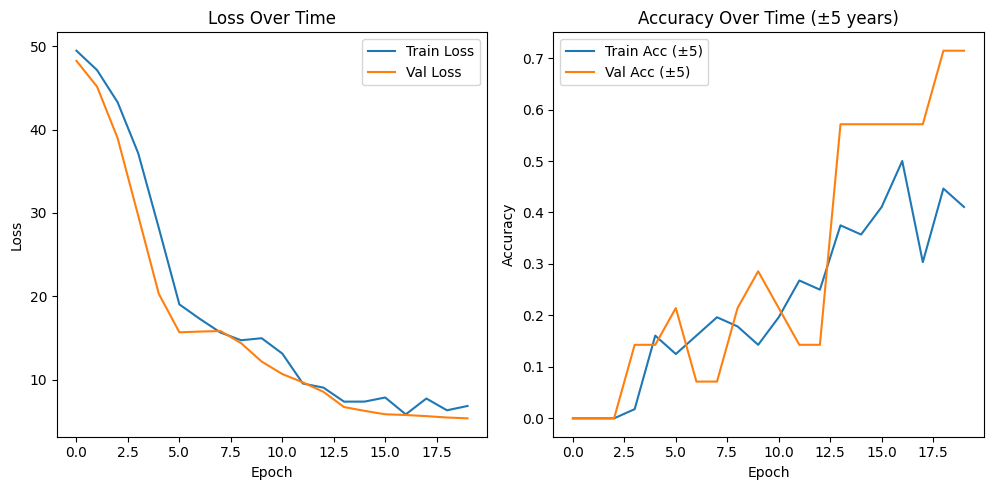

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
        
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Acc (±5)')
plt.plot(val_accuracies, label='Val Acc (±5)')
plt.title('Accuracy Over Time (±5 years)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
    

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Test prediction
sample_image_path = 'dataset/assessment-data/20/image1.jpg'  # Replace with your image path
if os.path.exists(sample_image_path):
    predicted_age = predict_age('best_age_regressor.pth', sample_image_path)
    print(f'Predicted age: {predicted_age:.1f} years')
else:
    print(f"Sample image not found: {sample_image_path}")

Predicted age: 24.6 years
